In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

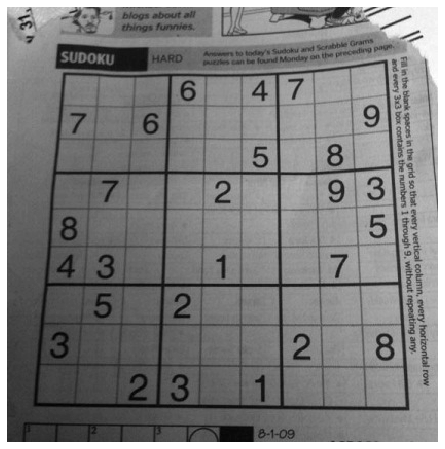

In [3]:
img_sudoku = cv2.cvtColor(cv2.imread('sudoku-original.jpg'), cv2.COLOR_BGR2GRAY)
show(img_sudoku)
img_sudoku_float = np.float32(img_sudoku)

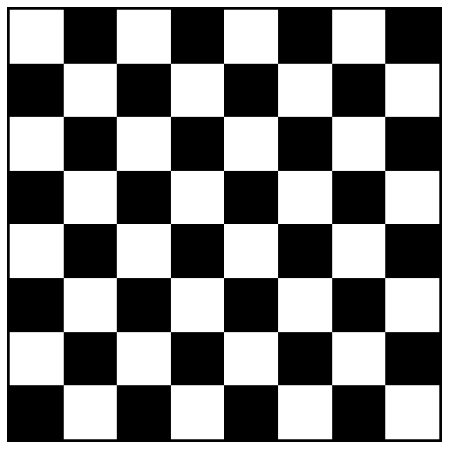

In [4]:
img_board = np.float32(cv2.cvtColor(cv2.imread('board.png'), cv2.COLOR_BGR2GRAY) / 255.0)
show(img_board)
img_board_float = np.float32(img_board)

## Gradientes de imagem

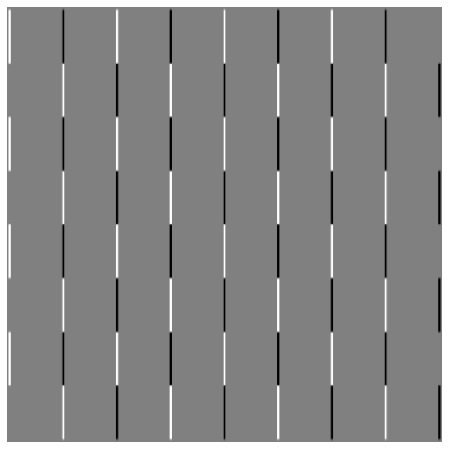

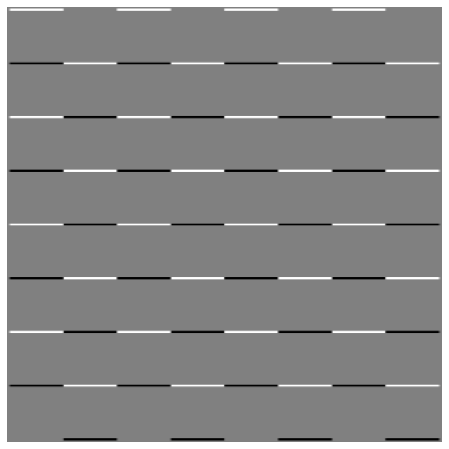

In [5]:
img_board_dx = cv2.Sobel(img_board_float, -1, 1, 0, ksize=5)
img_board_dy = cv2.Sobel(img_board_float, -1, 0, 1, ksize=5)

show(img_board_dx)
show(img_board_dy)

In [6]:
Ix2 = cv2.GaussianBlur(img_board_dx**2, (3, 3), cv2.BORDER_DEFAULT)
Iy2 = cv2.GaussianBlur(img_board_dy**2, (3, 3), cv2.BORDER_DEFAULT)
Ixy = cv2.GaussianBlur(img_board_dx * img_board_dy, (3, 3), cv2.BORDER_DEFAULT)

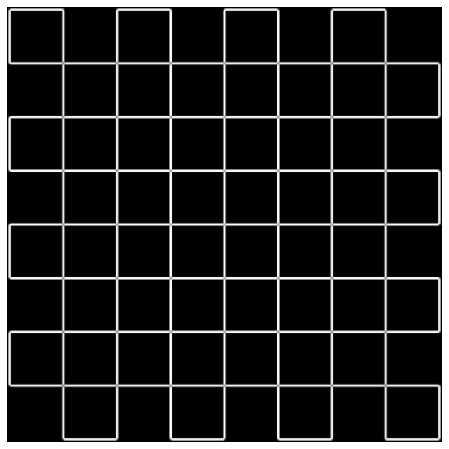

In [7]:
tr = Ix2 + Iy2
show(tr)

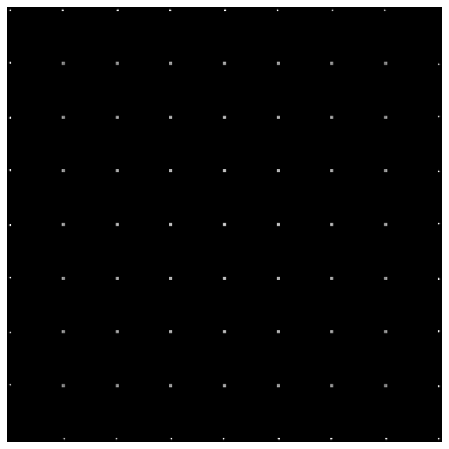

In [8]:
det = Ix2 * Iy2 - Ixy**2
show(det)

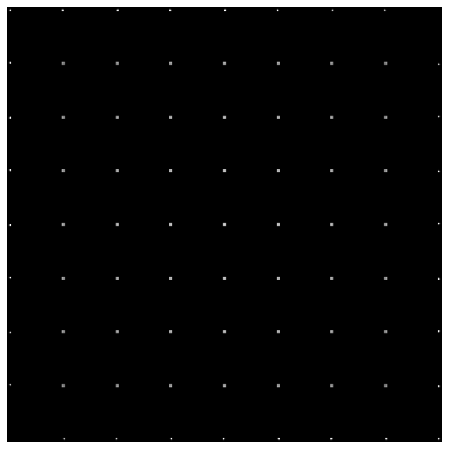

In [9]:
k = 0.04
harris = det - k*tr
show(harris)

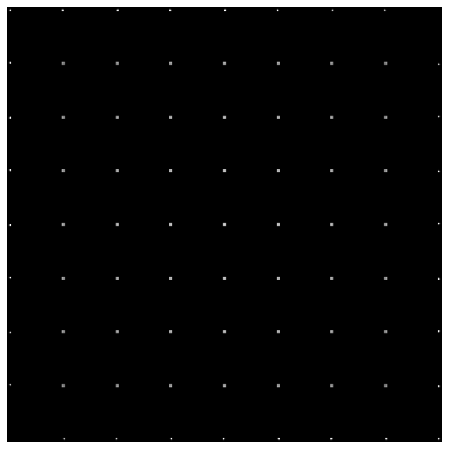

In [10]:
def harris_caseiro(img, k=0.04):
    Ix = cv2.Sobel(img, -1, 1, 0, ksize=5)
    Iy = cv2.Sobel(img, -1, 0, 1, ksize=5)
    Ix2 = cv2.GaussianBlur(img_board_dx**2, (3, 3), cv2.BORDER_DEFAULT)
    Iy2 = cv2.GaussianBlur(img_board_dy**2, (3, 3), cv2.BORDER_DEFAULT)
    Ixy = cv2.GaussianBlur(img_board_dx * img_board_dy, (3, 3), cv2.BORDER_DEFAULT)
    tr = Ix2 + Iy2
    det = Ix2 * Iy2 - Ixy**2
    return det - k*tr

harris = harris_caseiro(img_board_float)
show(harris)

## Detector de Harris

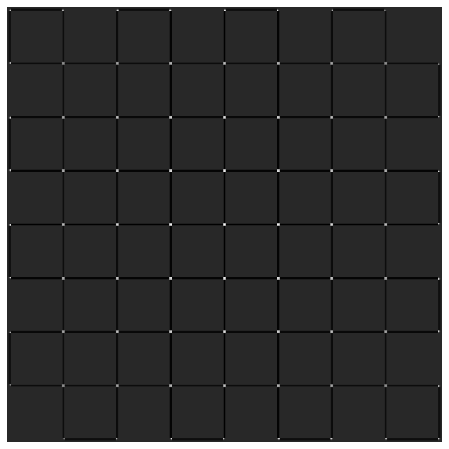

-0.017777782 -0.017777781933546066 -0.017777781933546066 -0.015805739909410477 0.09333335


In [11]:
img_board_harris = cv2.cornerHarris(img_board_float, 3, 3, 0.04)
show(img_board_harris)

print(np.min(img_board_harris), 
      np.percentile(img_board_harris, 0.05), 
      np.percentile(img_board_harris, 0.5), 
      np.percentile(img_board_harris, 0.95),
      np.max(img_board_harris))

In [12]:
from skimage.morphology import h_maxima, local_maxima
peaks_board_harris = local_maxima(h_maxima(img_board_harris, 0.01), indices=True)
print(len(peaks_board_harris[0]))

94


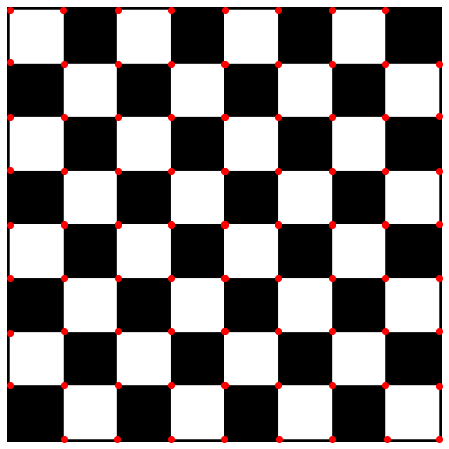

In [13]:
def show_points(img, px, py):
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap='gray')
    plt.scatter(px, py, color='r')
    plt.axis('off')
    plt.show()
    
show_points(img_board, peaks_board_harris[0], peaks_board_harris[1])

## Detector de Shi-Tomasi (Good-Features-To-Track)

(79, 1, 2)


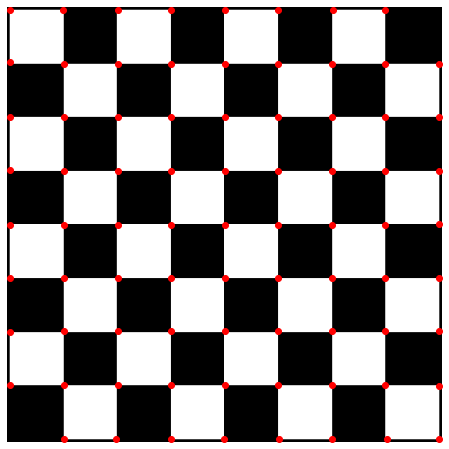

In [14]:
peaks_board_gftt = cv2.goodFeaturesToTrack(
    img_board_float,
    maxCorners=100,
    qualityLevel=0.001,
    minDistance=5,
    blockSize=3,
    useHarrisDetector=True,
    k=0.04
)
print(peaks_board_gftt.shape)
show_points(img_board, peaks_board_gftt[:,:,0], peaks_board_gftt[:,:,1])

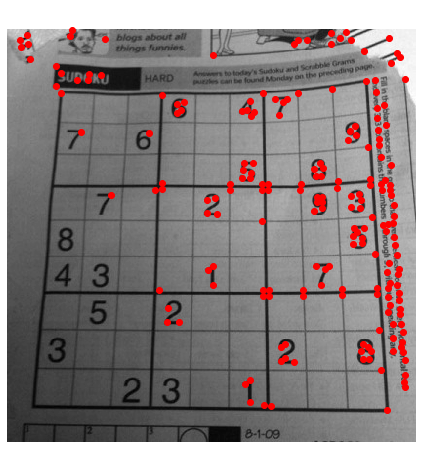

In [15]:
peaks_sudoku_gftt = cv2.goodFeaturesToTrack(
    img_sudoku_float,
    maxCorners=200,
    qualityLevel=0.001,
    minDistance=5,
    blockSize=5,
    useHarrisDetector=True,
    k=0.04
)
show_points(img_sudoku, peaks_sudoku_gftt[:,:,0], peaks_sudoku_gftt[:,:,1])

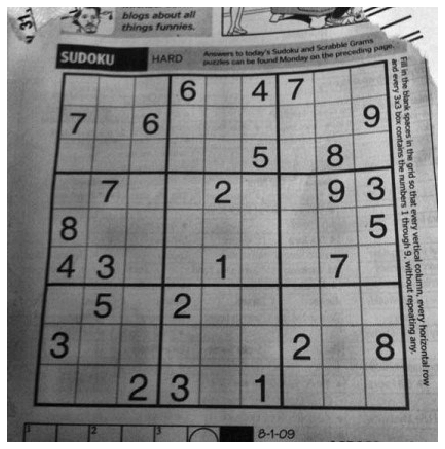

In [16]:
clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(15,15))
img_sudoku_fix = clahe.apply(img_sudoku)
show(img_sudoku_fix)

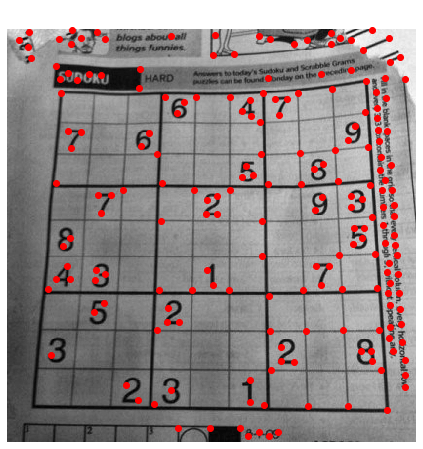

In [17]:
img_sudoku_fix_float = np.float32(img_sudoku_fix / 255.0)
peaks_sudoku_fix_gftt = cv2.goodFeaturesToTrack(
    img_sudoku_fix_float,
    maxCorners=200,
    qualityLevel=0.001,
    minDistance=10,
    blockSize=5,
    useHarrisDetector=True,
    k=0.04
)
show_points(img_sudoku_fix, peaks_sudoku_fix_gftt[:,:,0], peaks_sudoku_fix_gftt[:,:,1])

In [20]:
#cap = cv2.VideoCapture('slow_traffic_small.mp4')
cap = cv2.VideoCapture(0)

# Para não deixar encavalar os frames.
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

_, frame = cap.read()
frame = frame[70:-70, :]
mask = np.zeros_like(frame)

while True:
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    points = cv2.goodFeaturesToTrack(
        frame_gray, maxCorners=20, qualityLevel=0.3, minDistance=7, blockSize=7)

    for p in points:
        x,y = p.ravel()
        mask = cv2.circle(mask, (x, y), 5,  (0, 0, 255), -1)
    frame = cv2.add(frame, mask)

    cv2.imshow('frame', frame)

    _, frame = cap.read()
    frame = frame[70:-70, :]
        
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cv2.destroyAllWindows()

## Fluxo ótico

In [23]:
# Adaptado do exemplo do OpenCV em https://docs.opencv.org/ref/master/d4/dee/tutorial_optical_flow.html
cap = cv2.VideoCapture('slow_traffic_small.mp4')

# Parameters for Shi-Tomasi corner detection.
feature_params = {
    'maxCorners': 100,
    'qualityLevel': 0.3,
    'minDistance': 7,
    'blockSize': 7
}

# Parameters for Lucas-Kanade optical flow.
lk_params = {
    'winSize': (15, 15),
    'maxLevel': 2,
    'criteria': (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
}

# Create some random colors.
color = np.random.randint(0, 255, (100, 3))

# Take first frame and find corners in it.
_, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

# Create a mask image for drawing purposes.
mask = np.zeros_like(old_frame)

while True:
    _, frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow.
    p1, st, err = cv2.calcOpticalFlowPyrLK(
        old_gray, frame_gray, p0, None, **lk_params)

    # Select good points.
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # Draw the tracks.
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
        frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)
    img = cv2.add(frame, mask)

    cv2.imshow('frame', img)

    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points.
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

cv2.destroyAllWindows()